# Sentiment Analysis Using Simple RNN, LSTM, GRU


---


Submitted by :- Saurabh Roy

---
Guided by :- Dr. Muneendra Ojha


---




#Enabling and Checking for the GPU

In [1]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Installing
- Graphviz and Hierarchymagic for drawing graphs
- Keras
- Bokeh for visualizations

In [3]:
%%bash
apt install graphviz
pip install keras
pip install bokeh
pip install git+https://github.com/tla/ipython-hierarchymagic

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
  Cloning https://github.com/tla/ipython-hierarchymagic to /tmp/pip-req-build-jyph04v6
  Created wheel for ipython-hierarchymagic: filename=ipython_hierarchymagic-0.1-cp36-none-any.whl size=5025 sha256=19c6ce9968e75f8f4c32fdae2be36fe7764ba0eca9baae229e4511dfe2999d75
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmsxujkk/wheels/32/77/29/9bb9c3340e84bcdaa481575d1d18e60857fc184ba89a34e5f6
Successfully built ipython-hierarchymagic




  Running command git clone -q https://github.com/tla/ipython-hierarchymagic /tmp/pip-req-build-jyph04v6


In [0]:
%load_ext hierarchymagic

### Checking Bokeh


In [0]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook

In [0]:
output_notebook()

###Importing Numpy, Pandas, Keras

In [7]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


### Sentiment Analysis Data
Keras IMDB dataset is used here.This dataset consist of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative).[Dataset Link](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification)

In [0]:
from keras.datasets import imdb

In [0]:
#@title ### Dataset Parameters
#@markdown ---
#@markdown #### Number of words to use in classification
num_classification_words = 20000 #@param {type: "number"}
#@markdown #### The word limit for each entry
words_limit = 100 #@param {type: "number"}



In [10]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_classification_words)

17465344/17464789 [==============================] - 0s 0us/step


###Dataset Instances

In [11]:
word_to_id = keras.datasets.imdb.get_word_index()
INDEX_FROM=3
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0     #Padding
word_to_id["<START>"] = 1   #Start Index
word_to_id["<UNK>"] = 2     #Unkown Words
id_to_word = {value:key for key,value in word_to_id.items()}
for i in range(5):
  print("REVIEW",str(i+1),"\t",' '.join(id_to_word[id] for id in x_train[i] ))

1646592/1641221 [==============================] - 0s 0us/step
REVIEW 1 	 <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big

#### Data Preprocessing
The RNN will take sequences of constant length. This length is the `words_limit` which is defined to be 100. Since the reviews differ heavily in terms of lengths, I will trim each review to its first 100 words. If reviews are shorter than 100 words I will pad them with zeros.

In [0]:
import numpy as np
import random
import json
from six.moves import range
import six

In [0]:
def pad_sequences(sequences, maxlen=None):
    
    dtype='int32';padding='pre';truncating='pre';value=0.
    num_samples = len(sequences)

    lengths = []
    sample_shape = ()
    flag = True

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.

    for x in sequences:
        try:
            lengths.append(len(x))
            if flag and len(x):
                sample_shape = np.asarray(x).shape[1:]
                flag = False
        except TypeError:
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))

    if maxlen is None:
        maxlen = np.max(lengths)

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        trunc = np.asarray(trunc, dtype=dtype)

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
    return x

In [22]:
x_train_seq = pad_sequences(x_train, maxlen=words_limit)
x_test_seq = pad_sequences(x_test, maxlen=words_limit)

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [23]:
x_train_seq

array([[1415,   33,    6, ...,   19,  178,   32],
       [ 163,   11, 3215, ...,   16,  145,   95],
       [1301,    4, 1873, ...,    7,  129,  113],
       ...,
       [  11,    6, 4065, ...,    4, 3586,    2],
       [ 100, 2198,    8, ...,   12,    9,   23],
       [  78, 1099,   17, ...,  204,  131,    9]], dtype=int32)

Keras Models and Layers

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation, Input, LSTM, GRU

## RNN Model for Sentiment Analysis


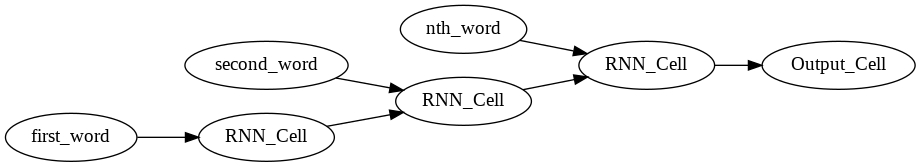

In [0]:
%%dot
digraph G {
    rankdir=LR;
    node1 [label="RNN_Cell"];
    node2 [label="RNN_Cell"];
    node3 [label="RNN_Cell"];
    first_word -> node1;
    second_word -> node2;
    nth_word -> node3;
    node1 -> node2;
    node2 -> node3;
    node3 -> Output_Cell;
}

In [0]:
rnn_input = Input(shape=(100,))
embedding = Embedding(num_classification_words, 128, input_length=words_limit)(rnn_input)
simple_rnn = SimpleRNN(128)(embedding)
dropout = Dropout(0.4)(simple_rnn)
dense = Dense(1)(dropout)
activation = Activation('sigmoid')(dense)
model = Model(rnn_input, activation)


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
___________________________________________________

Optimizer: Adam and Loss Model: Binary CrossEntropy

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
history=model.fit(x_train_seq, y_train, batch_size=32, epochs=3, validation_data=(x_test_seq, y_test))

Epoch 1/3
782/782 [==============================] - 79s 101ms/step - loss: 0.6375 - accuracy: 0.6354 - val_loss: 0.6657 - val_accuracy: 0.5817
Epoch 2/3
782/782 [==============================] - 79s 101ms/step - loss: 0.6258 - accuracy: 0.6465 - val_loss: 0.8133 - val_accuracy: 0.5606
Epoch 3/3
782/782 [==============================] - 79s 101ms/step - loss: 0.5792 - accuracy: 0.6939 - val_loss: 0.6133 - val_accuracy: 0.6598


Loss Score and Accuracy

In [0]:
score, acc = model.evaluate(x_test_seq, y_test, batch_size=32)
print("Score: ",score)
print("Accuracy: ",acc)

782/782 [==============================] - 6s 8ms/step - loss: 0.6133 - accuracy: 0.6598
Score:  0.6132510900497437
Accuracy:  0.6598399877548218


In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
p = figure(title="Loss History", x_axis_label='Time', y_axis_label='Loss')
range(len(history.history['val_loss']))
p.line(range(len(history.history['val_loss'])), history.history['val_loss'], 
       legend="Val. Loss", line_width=2, line_color='orange')
p.line(range(len(history.history['loss'])), history.history['loss'], 
       legend="Loss", line_width=2, line_color='blue')

GlyphRenderer(id='1051', ...)

In [0]:
output_notebook()
show(p)

In [0]:
p = figure(title="Accuracy History", x_axis_label='Time', y_axis_label='Loss')
p.line(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], 
       legend="Val. Acc", line_width=2, line_color='orange')
p.line(range(len(history.history['accuracy'])), history.history['accuracy'], 
       legend="Acc", line_width=2, line_color='blue')
output_notebook()
show(p)

# Conclusion
RNN and its kind are a great way to do sentiment analysis with minimum amount of workflow. The validation accuracy is going down and the model accuracy is going up [overfitting]. Since the change is negligible, we can ignore this.